## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


warnings.filterwarnings('ignore')

## Load data & Data Understanding

In [5]:
df = pd.read_csv('../data/new_train.csv')

print(f'Data has {df.shape[0]} rows and {df.shape[1]} columns')
print('\nData Sample:')
display(df.sample(3))

missing = df.isna().sum().sum()
print('\nMissing Values:', missing)

Data has 32950 rows and 16 columns

Data Sample:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
13385,34,admin.,married,high.school,no,no,no,telephone,jun,wed,638,1,999,0,nonexistent,yes
11626,33,blue-collar,single,basic.4y,no,no,no,telephone,jun,tue,147,1,999,0,nonexistent,no
3952,33,technician,married,professional.course,no,yes,no,telephone,oct,wed,171,1,999,0,nonexistent,yes



Missing Values: 0


In [6]:
# change the target column name from y to term_deposit
df['term_deposit'] = df['y']
df.drop('y', axis=1, inplace=True)

### Data Preprocessing

#### Feature Engineering

In [7]:
# Create a new column 'recently_contacted' based on the 'pdays' column. If 'pdays' is 999, set 'recently_contacted' to 0, else set it to 1.
df['recently_contacted'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)

# Drop the 'pdays' column as it's no longer needed
df.drop('pdays', axis=1, inplace=True)

# Create a new column 'previously_contacted' based on the 'previous' column. If 'previous' is greater than 0, set 'previously_contacted' to 'contacted', else set it to 'not contacted'.
df['previously_contacted'] = df['previous'].apply(lambda x: 'contacted' if x > 0 else 'not contacted')

# Drop the 'previous' column as it's no longer needed
df.drop('previous', axis=1, inplace=True)

# Create a dictionary to map certain job titles to broader categories
mapjob = {
    'student': 'unemployed',  
    'retired': 'unemployed',  
    'unknown': 'unemployed',  
    'entrepreneur': 'self-employed',  
    'housemaid': 'services', 
}

# Replace the job titles in the 'job' column based on the mapping dictionary
df['job'] = df['job'].replace(mapjob)

# Create a dictionary to map certain education levels to broader categories
mapedu = {
    'basic.9y': 'basic education',  
    'basic.6y': 'basic education',  
    'basic.4y': 'basic education', 
    'unknown': 'other',  
    'illiterate': 'other'  
}

# Replace the education levels in the 'education' column based on the mapping dictionary
df['education'] = df['education'].replace(mapedu)

# List of columns where 'unknown' values are to be removed
unknown_col = ['marital', 'housing', 'loan']

# Loop through the columns in the list and remove rows where the column value is 'unknown'
for col in unknown_col:
    df = df[df[col] != 'unknown']
    
# Drop the 'default' column as it's no longer needed
df = df.drop(columns='default', axis=1)

#### Train Test Split

In [8]:
# Drop the 'term_deposit' column from the dataframe and assign the remaining columns to X. This will be our feature set.
X = df.drop(columns='term_deposit', axis=1)

# Assign the 'term_deposit' column to y. This will be our target variable.
y = df['term_deposit']

# Split the dataset into training and test sets. 75% of the data will be used for training and 25% for testing. The 'random_state' parameter ensures reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1103)

# Print the number of rows and columns in the training set
print(f'Training set has {X_train.shape[0]} rows and {X_train.shape[1]} columns')

# Print the number of rows and columns in the test set
print(f'Test set has {X_test.shape[0]} rows and {X_test.shape[1]} columns')

Training set has 24067 rows and 14 columns
Test set has 8023 rows and 14 columns


#### Handling Outlier

In [9]:
# Define a function to handle outliers in a DataFrame using the capping method
def cap_outliers(data, cols):
    """
    This function caps the outliers in the specified columns of a DataFrame.
    
    Parameters:
    data (DataFrame): The DataFrame to process.
    cols (list): A list of column names to cap outliers in.
    
    Returns:
    DataFrame: The processed DataFrame with outliers capped.
    """
    # Loop over each specified column
    for col in cols:
        # Calculate the first quartile (Q1)
        Q1 = data[col].quantile(0.25)
        # Calculate the third quartile (Q3)
        Q3 = data[col].quantile(0.75)
        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1

        # Calculate the lower bound for outliers
        lower_bound = Q1 - 1.5 * IQR
        # Calculate the upper bound for outliers
        upper_bound = Q3 + 1.5 * IQR

        # Cap the outliers in the column by replacing them with the lower or upper bound
        data[col] = data[col].clip(lower_bound, upper_bound)
    
    # Return the processed DataFrame
    return data

# define columns to cap outliers in
outliers = X_train[['age', 'duration', 'campaign']]

# Apply the cap_outliers function to the DataFrame 'df', capping outliers in all numeric columns
X_capped = cap_outliers(X_train, outliers.columns)

##### Feature Selection

In [10]:
def chi_square_test(df, target, categorical_features):
    """
    This function performs a Chi-Square test of independence for each categorical feature 
    in a DataFrame with respect to a categorical target.
    
    Parameters:
    df (DataFrame): The DataFrame to process.
    target (str): The name of the target column.
    categorical_features (list): A list of the names of the categorical feature columns.
    
    Returns:
    DataFrame: A DataFrame that contains the p-value of the Chi-Square test for each feature, 
               sorted in ascending order.
    """
    # Create an empty DataFrame to store the results
    results = pd.DataFrame(columns=['feature', 'p-value'])

    # Perform the test for each categorical feature
    for i, feature in enumerate(categorical_features):
        # Create a contingency table
        contingency_table = pd.crosstab(df[feature], df[target])

        # Perform the Chi-Square test
        _, p, _, _ = chi2_contingency(contingency_table)

        # Add the results to the results DataFrame using loc
        results.loc[i] = [feature, p]

    # Return the results sorted by p-value
    return results.sort_values('p-value')


chi_train = pd.concat([X_capped, y_train], axis=1)

chi_test = pd.concat([X_test, y_test], axis=1)

Xcat = X_capped.select_dtypes(include='object').columns.tolist()

# Perform the Chi-Square test for the categorical features in the training set
chisq_train = chi_square_test(chi_train, 'term_deposit', Xcat)

chisq_test = chi_square_test(chi_test, 'term_deposit', Xcat)

display(chisq_train)
display(chisq_test)

,feature,p-value
6,month,0.000000e+00
8,poutcome,0.000000e+00
9,previously_contacted,2.341642e-205
5,contact,6.686268e-114
0,job,8.324080e-95
2,education,6.042295e-23
1,marital,3.076782e-17
7,day_of_week,2.256391e-02
3,housing,9.757824e-02
4,loan,7.861979e-01


,feature,p-value
8,poutcome,7.475909e-170
6,month,1.344512e-105
9,previously_contacted,8.868941e-58
0,job,1.072715e-29
5,contact,3.773153e-29
2,education,8.543321e-09
1,marital,5.969303e-07
3,housing,5.242323e-01
7,day_of_week,6.295824e-01
4,loan,7.055068e-01


In [11]:
# Set a significance level
alpha = 0.05

# Select the features where p-value is less than the significance level
selected_features = chisq_train[chisq_train['p-value'] < alpha]['feature'].values

# Select the features where p-value is less than the significance level
selected_features_test = chisq_test[chisq_test['p-value'] < alpha]['feature'].values

# Filter the training and test sets to include only the selected features
X_train_selected = X_capped[selected_features]

X_test_selected = X_test[selected_features]

# Display the selected features
print('Selected Features:')
print(selected_features)
print(selected_features_test)

Selected Features:
['month' 'poutcome' 'previously_contacted' 'contact' 'job' 'education'
 'marital' 'day_of_week']
['poutcome' 'month' 'previously_contacted' 'job' 'contact' 'education'
 'marital']


##### Encoding Categorical Data

In [12]:
# Create a dictionary to map education levels to numerical values
encode_edu = {
    'other': 0,
    'basic education': 1,
    'high.school': 2,
    'professional.course': 3,
    'university.degree': 4
}

# Replace the education levels in the 'education' column of the training set with the corresponding numerical values
X_train_selected['education'] = X_train_selected['education'].map(encode_edu)

# Replace the education levels in the 'education' column of the test set with the corresponding numerical values
X_test_selected['education'] = X_test_selected['education'].map(encode_edu)

# Convert categorical variables in the training set into dummy/indicator variables. The 'drop_first' parameter is set to True to avoid the dummy variable trap.
Xtr_encoded = pd.get_dummies(X_train_selected, drop_first=True).astype('int64')

# Convert categorical variables in the test set into dummy/indicator variables. The 'drop_first' parameter is set to True to avoid the dummy variable trap.
Xts_encoded = pd.get_dummies(X_test_selected, drop_first=True).astype('int64')

# Replace the 'no' and 'yes' values in the target variable of the training set with 0 and 1 respectively
y_train = y_train.map({'no': 0, 'yes': 1})

# Replace the 'no' and 'yes' values in the target variable of the test set with 0 and 1 respectively
y_test = y_test.map({'no': 0, 'yes': 1})

##### Feature Scaling

In [13]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
Xtr_scaled = scaler.fit_transform(Xtr_encoded)

Xtr_scaled = pd.DataFrame(Xtr_scaled, columns=Xtr_encoded.columns)

Xts_scaled = scaler.transform(Xts_encoded)

#### Handle Imbalance Data

In [14]:
print(Xtr_scaled.shape)
print(y_train.shape)

(24067, 26)
(24067,)


In [15]:
# Create a SMOTE instance
smote = SMOTE(random_state=42)

# Fit the SMOTE instance to the data and resample the data
Xtr_resampled, ytr_resampled = smote.fit_resample(Xtr_scaled, y_train)

### Modelling

#### Define function to evaluate the model

In [16]:
def eval_model(model, X_train, y_train, X_test, y_test, thresshold):
    
    model.fit(X_train, y_train)

    pred_train = model.predict_proba(X_train)[:, 1]
    pred_test = model.predict_proba(X_test)[:, 1]

    # print auc score with roc auc score
    print('Train AUC:', roc_auc_score(y_train, pred_train))
    print('Test AUC:', roc_auc_score(y_test, pred_test))

    print('Train Recall:', recall_score(y_train, pred_train > thresshold))
    print('Test Recall:', recall_score(y_test, pred_test > thresshold))

    print('Train Precision:', precision_score(y_train, pred_train > thresshold))
    print('Test Precision:', precision_score(y_test, pred_test > thresshold))

#### Train and Evaluate Model

In [17]:
# Create a Logistic Regression model
lr = LogisticRegression(random_state=1103)

# evaluate the model
eval_model(lr, Xtr_resampled, ytr_resampled, Xts_scaled, y_test, 0.6)

Train AUC: 0.7637927725622893
Test AUC: 0.736767516730679
Train Recall: 0.4599934300061007
Test Recall: 0.451348182883939
Train Precision: 0.8285013946411969
Test Precision: 0.3591417910447761


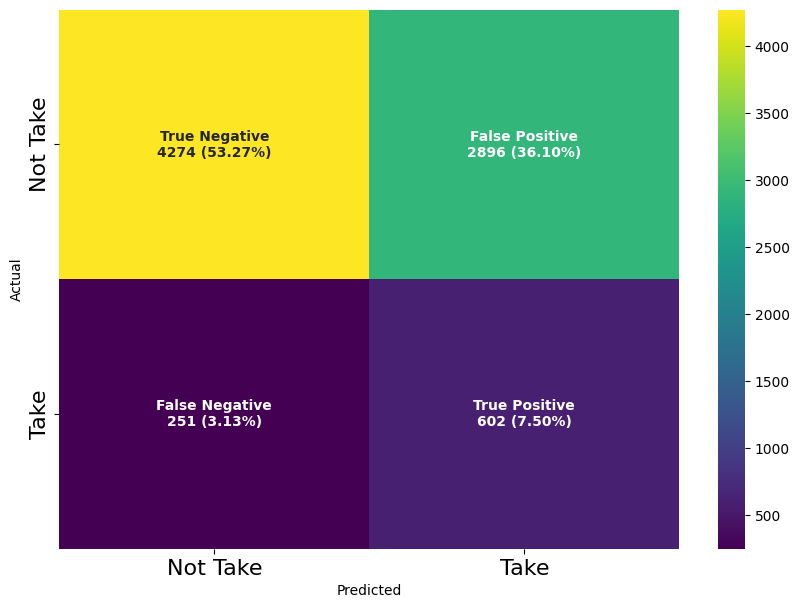

In [18]:
pred_test = lr.predict_proba(Xts_scaled)[:, 1]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_test > 0.42)

# Calculate the percentage of each category
percentage_matrix = cnf_matrix / cnf_matrix.sum()

# Define the labels
labels = np.array([['True Negative', 'False Positive'],
                   ['False Negative', 'True Positive']])

# Create labels with both count and percentage
new_labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
                          for label, value, percentage in zip(labels.flatten(), cnf_matrix.flatten(), percentage_matrix.flatten())])
             ).reshape(2,2)

# Plot confusion matrix using a heatmap
fig = plt.figure(figsize=(10,7))
fig.patch.set_facecolor('white')  # Change figure color

sns.heatmap(cnf_matrix, annot=new_labels, fmt='', cmap='viridis', annot_kws={"weight": "bold"})
# plt.title('Confusion Matrix LightGBM Model', fontsize=13, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Change label colors
plt.gca().xaxis.label.set_color('black')
plt.gca().yaxis.label.set_color('black')

plt.xticks(ticks=[0.5, 1.5], labels=['Not Take', 'Take'], fontsize=16)
plt.yticks(ticks=[0.5, 1.5], labels=['Not Take', 'Take'], fontsize=16)
plt.show()

#### Tune Selected Model Hyperparameter for Enhance Model Performance

In [19]:
# logistic regression hyperparameter tuning

# Define the hyperparameters to search
hyperparameters = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': np.arange(100, 1000, 100),
}

# Create a RandomizedSearchCV object
lr_random_search = RandomizedSearchCV(lr, hyperparameters, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1, random_state=1103)

# Fit the RandomizedSearchCV object to the data
lr_random_search.fit(Xtr_resampled, ytr_resampled)

# Get the best hyperparameters from the search
best_params = lr_random_search.best_params_
print(best_params)

{'solver': 'saga', 'penalty': 'l1', 'max_iter': 700, 'C': 0.23357214690901212}


In [20]:
# Create a Logistic Regression model with the best hyperparameters
lr_best = LogisticRegression(**best_params, random_state=1103)

# evaluate the model
eval_model(lr_best, Xtr_resampled, ytr_resampled, Xts_scaled, y_test, 0.45)

Train AUC: 0.7638000709405006
Test AUC: 0.7368173858446929
Train Recall: 0.6698578065606082
Test Recall: 0.6400937866354045
Train Precision: 0.6895319066711753
Test Precision: 0.20457100037467216


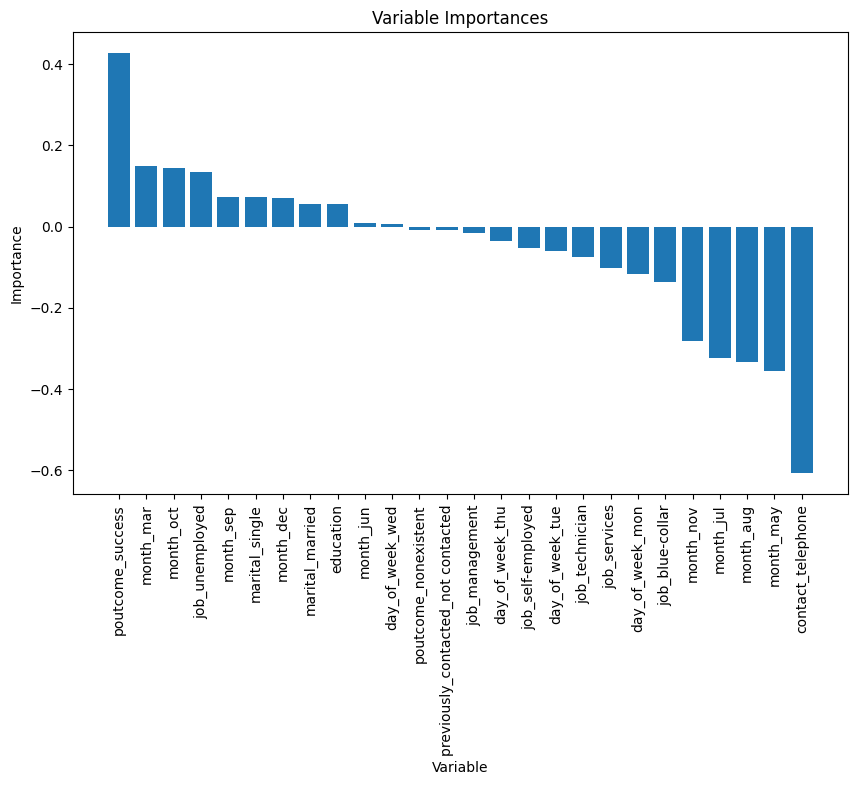

In [21]:
# Assume that 'model' is your fitted Logistic Regression model
feature_importance = lr_best.coef_[0]

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({'feature': Xtr_resampled.columns, 'importance': feature_importance})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# list of x locations for plotting
x_values = list(range(len(feature_importance_df.importance)))

# set the size of the plot
plt.figure(figsize=(10, 6))

# Make a bar chart
plt.bar(x_values, feature_importance_df.importance, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_importance_df.feature, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Show the plot
plt.show()